In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
# import plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot
# from plotly.offline import plot
# import ipywidgets as widgets

# # %matplotlib widget
# py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
# import umap

from datetime import datetime
# from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import TensorBoard

Using TensorFlow backend.
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [5]:
fname = "data/hr_lr.csv"
raw_data = pd.read_csv(fname, index_col=0).values
raw_data

array([[443.6580811 , 156.8248444 , 157.2230988 , ...,  32.40001297,
         10.53292751,   1.        ],
       [529.8170776 , 301.1605835 , 129.0924835 , ...,  44.31515884,
         12.01620674,   1.        ],
       [689.3991699 , 303.3375244 , 154.1694336 , ...,  63.73936081,
         10.89778328,   1.        ],
       ...,
       [630.8562622 , 303.7183533 , 210.3960266 , ...,  40.54899216,
         17.80297661,   0.        ],
       [479.3210144 , 263.7200623 , 136.6897278 , ...,  42.96739197,
         12.05090141,   0.        ],
       [767.0294189 , 488.8855896 , 134.025528  , ...,  36.10884857,
         15.40684414,   0.        ]])

In [6]:
X = raw_data[:, :-1]
Y = raw_data[:,-1].reshape(-1,1)
X.shape

(164, 333)

In [7]:
ZScaler = StandardScaler().fit(X)
X = ZScaler.transform(X)

## Example run using Grid Search

In [8]:
# Function to create model, required for KerasClassifier
def create_model(nodes=12):
    # create model
    model = Sequential()
    model.add(Dense(nodes, input_dim=333, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [15]:
%%time
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20]
num_nodes = [64,100,128]   #np.logspace(3, 8, num=6, base=2, dtype=int)
epochs = [500]
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=10)
grid_result = grid.fit(X, Y)

/home/smaug/anaconda3/envs/condatensor/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 4.53 s, sys: 162 ms, total: 4.7 s
Wall time: 32.4 s


In [16]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.512195 using {'batch_size': 20, 'epochs': 500, 'nodes': 100}
0.481707 (0.165652) with: {'batch_size': 20, 'epochs': 500, 'nodes': 64}
0.512195 (0.213239) with: {'batch_size': 20, 'epochs': 500, 'nodes': 100}
0.500000 (0.220914) with: {'batch_size': 20, 'epochs': 500, 'nodes': 128}


## DNN Search

In [8]:
def build_dnn(input_dim=333, nodes=(150,25), activation="elu",
              dropout_rate=(0.0,0.0,0.0), learning_rate = 0.001, reg_scale=0.01,
              momentum=0.0, nesterov=False):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    dnn.add(keras.layers.Dropout(rate=dropout_rate[0], input_shape=(input_dim,)))
    dnn.add(Dense(units = nodes[0], activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(dropout_rate[1]))
    dnn.add(Dense(units = nodes[1], activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(dropout_rate[2]))
    
    dnn.add(Dense(units=1, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    SGD=keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=nesterov)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [38]:
# Separating a hold out set that will be used for validation of the pipeline
data_df = pd.DataFrame(X)
labels_df = pd.Series(np.ravel(Y))
X_train, y_train, X_valid, y_valid = split_valid(data_df, labels_df, valid_size=0.2)
class_weight = compute_class_weight("balanced", np.unique(y_train), y_train)
print(X_train.shape)
y_train.value_counts()

(131, 333)


1.0    79
0.0    52
dtype: int64

In [43]:
%%time
dnn = build_dnn()
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time),
                          update_freq="epoch", write_graph=False)  # Very weird bug where TB will stop writing after some epochs...

history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=1000, batch_size=20, verbose=0, callbacks=[])

CPU times: user 13 s, sys: 606 ms, total: 13.6 s
Wall time: 7.12 s


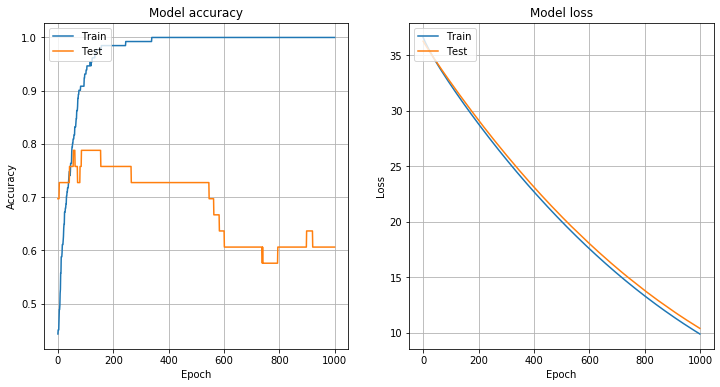

33/33 [==============================] - 0s 40us/step
Loss:10.404, Acc:0.6061


In [44]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

## Architecture Search

In [9]:
exp_2 = np.logspace(6,8, num=3, base=2, dtype=int)
exp_2_combs = []
for i,x in enumerate(exp_2):
    for j in range(0,i+1):
        exp_2_combs.append((x,exp_2[j]))
exp_2_combs

[(64, 64), (128, 64), (128, 128), (256, 64), (256, 128), (256, 256)]

### Only searching powers of 2

In [10]:
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import StratifiedKFold

prec_scorer = make_scorer(precision_score, pos_label=0)

# def prec_scorer(y_true, y_pred):
#     return precision_score(np.ravel(y_true), np.ravel(y_pred), pos_label=0)

# Performing 10-Fold split
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring={"acc":"accuracy","prec": prec_scorer}

In [12]:
# create model
model = KerasClassifier(build_fn=build_dnn, verbose=0)
# define the grid search parameters
batch_size = [10,20]
num_nodes = exp_2_combs
epochs = [x for x in range(200,1100,100)]
class_weights = [compute_class_weight("balanced", np.unique(np.ravel(Y)), np.ravel(Y))]
rates = [(0,0,0),(0,0.2,0.2)]

param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes, class_weight=class_weights, dropout_rate=rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=6,
                    cv=splitter, scoring=scoring, refit="prec", verbose=2)
grid

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f169f1d3590>,
             iid='warn', n_jobs=6,
             param_grid={'batch_size': [10, 20],
                         'class_weight': [array([1.26153846, 0.82828283])],
                         'dropout_rate': [(0, 0, 0), (0, 0.2, 0.2)],
                         'epochs': [200, 300, 400, 500, 600, 700, 800, 900,
                                    1000],
                         'nodes': [(64, 64), (128, 64), (128, 128), (256, 64),
                                   (256, 128), (256, 256)]},
             pre_dispatch='2*n_jobs', refit='prec', return_train_score=False,
             scoring={'acc': 'accuracy',
                      'prec': make_scorer(precision_score, pos_label=0)},
             verbose=2)

In [ ]:
%%time
grid_result = grid.fit(X, Y)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   23.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  3.8min


In [114]:
grid_result.cv_results_

{'mean_fit_time': array([4.36234384]),
 'std_fit_time': array([0.21250163]),
 'mean_score_time': array([0.07706952]),
 'std_score_time': array([0.04474658]),
 'param_batch_size': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_nodes': masked_array(data=[(150, 25)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 20, 'epochs': 100, 'nodes': (150, 25)}],
 'split0_test_acc': array([0.52941176]),
 'split1_test_acc': array([0.52941176]),
 'split2_test_acc': array([0.58823529]),
 'split3_test_acc': array([0.29411765]),
 'split4_test_acc': array([0.52941176]),
 'split5_test_acc': array([0.4375]),
 'split6_test_acc': array([0.75]),
 'split7_test_acc': array([0.6875]),
 'split8_test_acc': array([0.6875]),
 'split9_test_acc': array([0.53333333]),
 'mean_t

In [116]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_acc']
stds = grid_result.cv_results_['std_test_acc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%.4f +/- %.3f with: %r" % (mean, stdev, param))

Best: 0.423064 using {'batch_size': 20, 'epochs': 100, 'nodes': (150, 25)}
0.5549 +/- 0.126 with: {'batch_size': 20, 'epochs': 100, 'nodes': (150, 25)}


In [117]:
results = pd.DataFrame(grid_result.cv_results_)
batch_1 = results[results["param_batch_size"]==1]

In [119]:
ranked_results = results.sort_values(by="rank_test_prec")
batches = {}

In [33]:
for b,_df in ranked_results.groupby(by="param_batch_size"):
    batches[b] = _df

In [120]:
# batches[20]["mean_test_score"].plot(kind="bar", figsize=(24,12), grid=True)

In [38]:
for b in batches.keys():
    print(batches[b].iloc[0][["mean_test_score","std_test_score", "mean_fit_time", "params"]])

mean_test_score                                             0.670732
std_test_score                                               0.17625
mean_fit_time                                                146.572
params             {'batch_size': 1, 'epochs': 300, 'nodes': (256...
Name: 47, dtype: object
mean_test_score                                             0.609756
std_test_score                                              0.148871
mean_fit_time                                                8.89974
params             {'batch_size': 10, 'epochs': 300, 'nodes': (12...
Name: 123, dtype: object
mean_test_score                                             0.615854
std_test_score                                              0.146184
mean_fit_time                                                7.88975
params             {'batch_size': 15, 'epochs': 400, 'nodes': (12...
Name: 213, dtype: object
mean_test_score                                             0.615854
std_test_score               

In [45]:
results.to_csv("gs_exp_2_nodes.csv")

In [ ]:
exp_2 = np.logspace(4, 8, num=5, base=, dtype=int)
exp_2_combs = []
for i,x in enumerate(exp_2):
    for j in range(0,i):
        exp_2_combs.append((x,exp_2[j]))
exp_2_combs

In [17]:
mult_25 = [x for x in range(25,251,25)]
node_combs = []
for i,x in enumerate(mult_25):
    for j in range(0,i+1):
        node_combs.append((x,mult_25[j]))
print(len(node_combs))
# node_combs

55


In [55]:
[x for x in range(100,1300,100)]

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [57]:
# create model
model = KerasClassifier(build_fn=build_dnn, verbose=0)

# define the grid search parameters
batch_size = [20]
drop_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
num_nodes = [(200,200)] #node_combs
epochs = [x for x in range(300,1300,100)]
class_weights = [compute_class_weight("balanced", np.unique(np.ravel(Y)), np.ravel(Y))]


param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes,
                  dropout_rate=drop_rates, class_weight=class_weights)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=10, refit=False, verbose=2)
grid

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a2cad2a90>,
             iid='warn', n_jobs=4,
             param_grid={'batch_size': [20],
                         'class_weight': [array([1.26153846, 0.82828283])],
                         'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                         'epochs': [300, 400, 500, 600, 700, 800, 900, 1000,
                                    1100, 1200],
                         'nodes': [(200, 200)]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=None, verbose=2)

## Start with coarse settings
> ## Then do an "axis" search

## Learning rate, regularizer scale, more architectures+dropout combos ..?

> ## Shortlist (200,200), (175,175), (125,75), (125,25), (256,32)
> ## LR: 0.0001, 0.0003,0.0005
> ## Dropout 0.1 to 0.5 - Maybe combinations of (high,low)
> ## Epochs: [100 - 1000, 50 incs]

use group by to figure out trends